## Library

In [1]:
import PIL
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm import tqdm_notebook as tqdm
from itertools import permutations

from puzzle_cfn import PuzzleCFN_30, PuzzleCFN
from puzzle_image_loader import PuzzleDataset1000 as PuzzleDataset
from util.tester import visualLoss

gpu_ids = []
device_names = []
if torch.cuda.is_available():
    for gpu_id in range(torch.cuda.device_count()):
        gpu_ids += [gpu_id]
        device_names += [torch.cuda.get_device_name(gpu_id)]
print(gpu_ids)
print(device_names)

if len(gpu_ids) > 1:
    gpu = 'cuda:' + str(gpu_ids[0])  # GPU Number
else:
    gpu = "cuda" if torch.cuda.is_available() else "cpu"

[0, 1, 2, 3]
['NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090']


## Hyper parameter

In [2]:
device = gpu
CLASSES = 1000
LEARNING_RATE = 7e-05  # 1e-03
BATCH_SIZE = 256  # 256
NUM_EPOCHS = 20
NUM_WORKERS = 2
TASK_NAME = 'puzzle_imagenet_1000'
MODEL_NAME = 'cfn'
pre_model_path = f'./save/{TASK_NAME}_{MODEL_NAME}_ep{NUM_EPOCHS}_lr{LEARNING_RATE}_b{BATCH_SIZE}.pt'
pre_load_model_path = './save/xxx.pt'

## Dataset

In [3]:
# transform = transforms.Compose([
#     transforms.Pad(padding=3),
#     transforms.CenterCrop(30),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

transform = transforms.Compose([
    transforms.Resize(256, interpolation=PIL.Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.Pad(padding=(0, 0, 1, 1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
# train_dataset = PuzzleDataset(dataset=train_dataset)
# train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# val_dataset = Subset(train_dataset, list(range(int(0.2*len(train_dataset)))))
# val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
# test_dataset = PuzzleDataset(dataset=test_dataset)
# test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

train_dataset = datasets.ImageFolder('../datasets/ImageNet/train', transform=transform)
train_dataset = PuzzleDataset(dataset=train_dataset)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataset = Subset(train_dataset, list(range(int(0.01*len(train_dataset)))))
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataset = datasets.ImageFolder('../datasets/ImageNet/val', transform=transform)
test_dataset = PuzzleDataset(dataset=test_dataset)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

## Pre-training class

In [4]:
class PreTrainer(object):
    def __init__(self):
        self.model = None
        self.optimizer = None
        self.epochs = []
        self.losses = []
        numbers = list(range(9))
        permutation_list = permutations(numbers)
        permutations_array = np.array(list(permutation_list))
        self.permutations = permutations_array

    def process(self, load=False):
        self.build_model(load)
        self.pretrain_model()
        self.save_model()

    def build_model(self, load):
        self.model = PuzzleCFN(classes=CLASSES).to(device)
        print(f'Parameter: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}')
        if load:
            checkpoint = torch.load(pre_load_model_path)
            self.epochs = checkpoint['epochs']
            self.model.load_state_dict(checkpoint['model'])
            self.losses = checkpoint['losses']
            print(f'Parameter: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}')
            print(f'Epoch: {self.epochs[-1]}')
            print(f'****** Reset epochs and losses ******')
            self.epochs = []
            self.losses = []

    def pretrain_model(self):
        model = self.model
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

        model.train()
        for epoch in range(NUM_EPOCHS):
            running_loss = 0.
            for batch_idx, (images, labels, original) in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                inter = 100
                if batch_idx % inter == inter - 1:
                    print(f'[Epoch {epoch + 1}] [Batch {batch_idx + 1}] Loss: {running_loss / inter:.4f}')
                    self.epochs.append(epoch + 1)
                    self.model = model
                    self.optimizer = optimizer
                    self.losses.append(running_loss / inter)
                    running_loss = 0.
            scheduler.step()
            self.save_model()
            visualLoss(self.losses)
            self.val_model(epoch)
        print('****** Finished Fine-tuning ******')
        self.model = model

    def val_model(self, epoch=-1):
        model = self.model

        model.eval()

        total = 0
        correct = 0
        with torch.no_grad():
            for batch_idx, (images, labels, original) in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                _, pred = torch.max(outputs.data, 1)
                labels_ = torch.tensor([self.idx2order1000(label) for label in labels])
                pred_ = torch.tensor([self.idx2order1000(p) for p in pred])
                total += labels_.size(0) * labels_.size(1)
                correct += (pred_ == labels_).sum().item()

        print(f'[Epoch {epoch + 1}] Accuracy on the test set: {100 * correct / total:.2f}%')
        torch.set_printoptions(precision=2)
        total = labels_.size(1)
        correct = (pred_[0] == labels_[0]).sum().item()
        print(f'[Sample result]')
        print(torch.cat((pred_[0].view(9, -1), labels_[0].view(9, -1)), dim=1))
        print(f'Accuracy: {100 * correct / total:.2f}%')

    def save_model(self):
        checkpoint = {
            'epochs': self.epochs,
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'losses': self.losses,
        }
        torch.save(checkpoint, pre_model_path)
        print(f"****** Model checkpoint saved at epochs {self.epochs[-1]} ******")

    def idx2order(self, idx):
        numbers = list(range(9))
        permutation_list = permutations(numbers)
        permutations_array = np.array(list(permutation_list))
        return permutations_array[idx]

    def idx2order1000(self, idx):
        permutations_array = np.load(f'./data/permutations_1000.npy')
        return permutations_array[idx]

Parameter: 46544232


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 1] [Batch 100] Loss: 6.9081
[Epoch 1] [Batch 200] Loss: 6.9081
[Epoch 1] [Batch 300] Loss: 6.9079
[Epoch 1] [Batch 400] Loss: 6.9078
[Epoch 1] [Batch 500] Loss: 6.9079
[Epoch 1] [Batch 600] Loss: 6.9079
[Epoch 1] [Batch 700] Loss: 6.9078
[Epoch 1] [Batch 800] Loss: 6.9079
[Epoch 1] [Batch 900] Loss: 6.9079
[Epoch 1] [Batch 1000] Loss: 6.9077
[Epoch 1] [Batch 1100] Loss: 6.9077
[Epoch 1] [Batch 1200] Loss: 6.9078
[Epoch 1] [Batch 1300] Loss: 6.9079
[Epoch 1] [Batch 1400] Loss: 6.9073
[Epoch 1] [Batch 1500] Loss: 6.9080
[Epoch 1] [Batch 1600] Loss: 6.9075
[Epoch 1] [Batch 1700] Loss: 6.9069
[Epoch 1] [Batch 1800] Loss: 6.9052
[Epoch 1] [Batch 1900] Loss: 6.8650
[Epoch 1] [Batch 2000] Loss: 6.7347
[Epoch 1] [Batch 2100] Loss: 6.5920
[Epoch 1] [Batch 2200] Loss: 6.4800
[Epoch 1] [Batch 2300] Loss: 6.3771
[Epoch 1] [Batch 2400] Loss: 6.3198
[Epoch 1] [Batch 2500] Loss: 6.2641
[Epoch 1] [Batch 2600] Loss: 6.2181
[Epoch 1] [Batch 2700] Loss: 6.1726
[Epoch 1] [Batch 2800] Loss: 6.1423
[

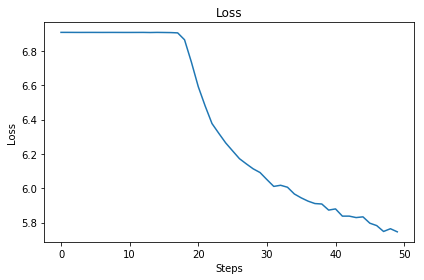

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 1] Accuracy on the test set: 19.05%
[Sample result]
tensor([[1, 1],
        [4, 5],
        [8, 8],
        [2, 4],
        [5, 6],
        [0, 2],
        [6, 3],
        [3, 0],
        [7, 7]])
Accuracy: 33.33%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 2] [Batch 100] Loss: 5.6035
[Epoch 2] [Batch 200] Loss: 5.6093
[Epoch 2] [Batch 300] Loss: 5.5968
[Epoch 2] [Batch 400] Loss: 5.5734
[Epoch 2] [Batch 500] Loss: 5.5367
[Epoch 2] [Batch 600] Loss: 5.5001
[Epoch 2] [Batch 700] Loss: 5.4639
[Epoch 2] [Batch 800] Loss: 5.4165
[Epoch 2] [Batch 900] Loss: 5.3491
[Epoch 2] [Batch 1000] Loss: 5.3083
[Epoch 2] [Batch 1100] Loss: 5.2583
[Epoch 2] [Batch 1200] Loss: 5.2378
[Epoch 2] [Batch 1300] Loss: 5.1912
[Epoch 2] [Batch 1400] Loss: 5.1500
[Epoch 2] [Batch 1500] Loss: 5.1364
[Epoch 2] [Batch 1600] Loss: 5.0939
[Epoch 2] [Batch 1700] Loss: 5.0674
[Epoch 2] [Batch 1800] Loss: 5.0647
[Epoch 2] [Batch 1900] Loss: 5.0487
[Epoch 2] [Batch 2000] Loss: 5.0215
[Epoch 2] [Batch 2100] Loss: 4.9934
[Epoch 2] [Batch 2200] Loss: 4.9753
[Epoch 2] [Batch 2300] Loss: 4.9593
[Epoch 2] [Batch 2400] Loss: 4.9397
[Epoch 2] [Batch 2500] Loss: 4.9156
[Epoch 2] [Batch 2600] Loss: 4.8903
[Epoch 2] [Batch 2700] Loss: 4.9038
[Epoch 2] [Batch 2800] Loss: 4.8753
[

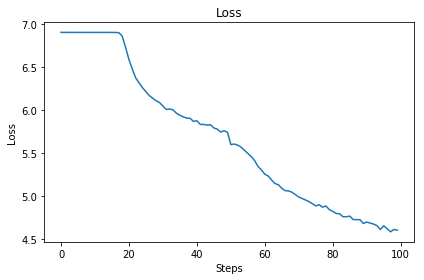

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 2] Accuracy on the test set: 29.76%
[Sample result]
tensor([[4, 1],
        [3, 5],
        [2, 8],
        [7, 4],
        [5, 6],
        [8, 2],
        [0, 3],
        [1, 0],
        [6, 7]])
Accuracy: 0.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 3] [Batch 100] Loss: 4.5834
[Epoch 3] [Batch 200] Loss: 4.5478
[Epoch 3] [Batch 300] Loss: 4.5693
[Epoch 3] [Batch 400] Loss: 4.5546
[Epoch 3] [Batch 500] Loss: 4.5454
[Epoch 3] [Batch 600] Loss: 4.5188
[Epoch 3] [Batch 700] Loss: 4.5112
[Epoch 3] [Batch 800] Loss: 4.4726
[Epoch 3] [Batch 900] Loss: 4.4665
[Epoch 3] [Batch 1000] Loss: 4.4882
[Epoch 3] [Batch 1100] Loss: 4.4795
[Epoch 3] [Batch 1200] Loss: 4.4565
[Epoch 3] [Batch 1300] Loss: 4.4506
[Epoch 3] [Batch 1400] Loss: 4.4057
[Epoch 3] [Batch 1500] Loss: 4.4360
[Epoch 3] [Batch 1600] Loss: 4.4202
[Epoch 3] [Batch 1700] Loss: 4.4134
[Epoch 3] [Batch 1800] Loss: 4.3697
[Epoch 3] [Batch 1900] Loss: 4.3856
[Epoch 3] [Batch 2000] Loss: 4.3610
[Epoch 3] [Batch 2100] Loss: 4.3520
[Epoch 3] [Batch 2200] Loss: 4.3473
[Epoch 3] [Batch 2300] Loss: 4.2927
[Epoch 3] [Batch 2400] Loss: 4.3236
[Epoch 3] [Batch 2500] Loss: 4.2854
[Epoch 3] [Batch 2600] Loss: 4.2850
[Epoch 3] [Batch 2700] Loss: 4.2712
[Epoch 3] [Batch 2800] Loss: 4.2656
[

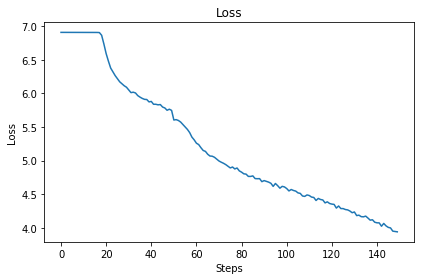

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 3] Accuracy on the test set: 36.15%
[Sample result]
tensor([[1, 1],
        [5, 5],
        [8, 8],
        [4, 4],
        [6, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 100.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 4] [Batch 100] Loss: 3.9250
[Epoch 4] [Batch 200] Loss: 3.9001
[Epoch 4] [Batch 300] Loss: 3.8999
[Epoch 4] [Batch 400] Loss: 3.8725
[Epoch 4] [Batch 500] Loss: 3.8866
[Epoch 4] [Batch 600] Loss: 3.8510
[Epoch 4] [Batch 700] Loss: 3.8543
[Epoch 4] [Batch 800] Loss: 3.8472
[Epoch 4] [Batch 900] Loss: 3.8189
[Epoch 4] [Batch 1000] Loss: 3.8176
[Epoch 4] [Batch 1100] Loss: 3.8125
[Epoch 4] [Batch 1200] Loss: 3.8071
[Epoch 4] [Batch 1300] Loss: 3.8005
[Epoch 4] [Batch 1400] Loss: 3.7790
[Epoch 4] [Batch 1500] Loss: 3.7884
[Epoch 4] [Batch 1600] Loss: 3.7715
[Epoch 4] [Batch 1700] Loss: 3.7434
[Epoch 4] [Batch 1800] Loss: 3.7481
[Epoch 4] [Batch 1900] Loss: 3.7459
[Epoch 4] [Batch 2000] Loss: 3.7346
[Epoch 4] [Batch 2100] Loss: 3.7224
[Epoch 4] [Batch 2200] Loss: 3.7250
[Epoch 4] [Batch 2300] Loss: 3.6882
[Epoch 4] [Batch 2400] Loss: 3.7090
[Epoch 4] [Batch 2500] Loss: 3.6866
[Epoch 4] [Batch 2600] Loss: 3.6520
[Epoch 4] [Batch 2700] Loss: 3.6752
[Epoch 4] [Batch 2800] Loss: 3.6511
[

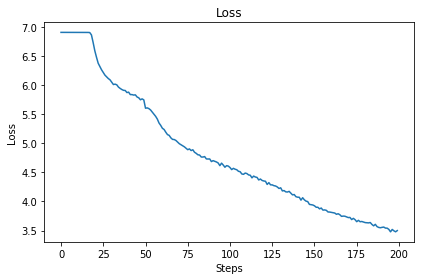

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 4] Accuracy on the test set: 41.49%
[Sample result]
tensor([[0, 1],
        [6, 5],
        [3, 8],
        [2, 4],
        [7, 6],
        [4, 2],
        [1, 3],
        [8, 0],
        [5, 7]])
Accuracy: 0.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 5] [Batch 100] Loss: 3.4548
[Epoch 5] [Batch 200] Loss: 3.4342
[Epoch 5] [Batch 300] Loss: 3.4251
[Epoch 5] [Batch 400] Loss: 3.4349
[Epoch 5] [Batch 500] Loss: 3.4500
[Epoch 5] [Batch 600] Loss: 3.4394
[Epoch 5] [Batch 700] Loss: 3.4213
[Epoch 5] [Batch 800] Loss: 3.4015
[Epoch 5] [Batch 900] Loss: 3.3718
[Epoch 5] [Batch 1000] Loss: 3.3746
[Epoch 5] [Batch 1100] Loss: 3.3922
[Epoch 5] [Batch 1200] Loss: 3.3586
[Epoch 5] [Batch 1300] Loss: 3.3558
[Epoch 5] [Batch 1400] Loss: 3.3943
[Epoch 5] [Batch 1500] Loss: 3.3638
[Epoch 5] [Batch 1600] Loss: 3.3600
[Epoch 5] [Batch 1700] Loss: 3.3347
[Epoch 5] [Batch 1800] Loss: 3.3329
[Epoch 5] [Batch 1900] Loss: 3.2867
[Epoch 5] [Batch 2000] Loss: 3.2794
[Epoch 5] [Batch 2100] Loss: 3.3088
[Epoch 5] [Batch 2200] Loss: 3.3157
[Epoch 5] [Batch 2300] Loss: 3.2956
[Epoch 5] [Batch 2400] Loss: 3.2573
[Epoch 5] [Batch 2500] Loss: 3.2693
[Epoch 5] [Batch 2600] Loss: 3.2617
[Epoch 5] [Batch 2700] Loss: 3.2497
[Epoch 5] [Batch 2800] Loss: 3.2599
[

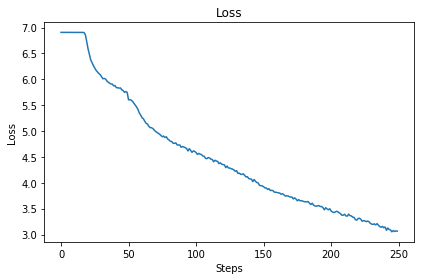

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 5] Accuracy on the test set: 46.16%
[Sample result]
tensor([[1, 1],
        [5, 5],
        [8, 8],
        [4, 4],
        [6, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 100.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 6] [Batch 100] Loss: 3.0105
[Epoch 6] [Batch 200] Loss: 3.0117
[Epoch 6] [Batch 300] Loss: 2.9998
[Epoch 6] [Batch 400] Loss: 3.0110
[Epoch 6] [Batch 500] Loss: 2.9758
[Epoch 6] [Batch 600] Loss: 2.9620
[Epoch 6] [Batch 700] Loss: 2.9888
[Epoch 6] [Batch 800] Loss: 2.9841
[Epoch 6] [Batch 900] Loss: 2.9651
[Epoch 6] [Batch 1000] Loss: 2.9383
[Epoch 6] [Batch 1100] Loss: 2.9503
[Epoch 6] [Batch 1200] Loss: 2.9181
[Epoch 6] [Batch 1300] Loss: 2.9178
[Epoch 6] [Batch 1400] Loss: 2.8893
[Epoch 6] [Batch 1500] Loss: 2.9201
[Epoch 6] [Batch 1600] Loss: 2.8924
[Epoch 6] [Batch 1700] Loss: 2.8863
[Epoch 6] [Batch 1800] Loss: 2.8771
[Epoch 6] [Batch 1900] Loss: 2.8800
[Epoch 6] [Batch 2000] Loss: 2.8517
[Epoch 6] [Batch 2100] Loss: 2.8599
[Epoch 6] [Batch 2200] Loss: 2.8531
[Epoch 6] [Batch 2300] Loss: 2.8550
[Epoch 6] [Batch 2400] Loss: 2.8235
[Epoch 6] [Batch 2500] Loss: 2.8288
[Epoch 6] [Batch 2600] Loss: 2.7911
[Epoch 6] [Batch 2700] Loss: 2.7864
[Epoch 6] [Batch 2800] Loss: 2.8002
[

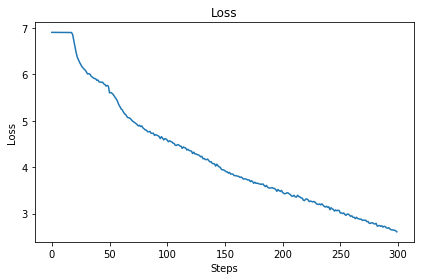

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 6] Accuracy on the test set: 51.66%
[Sample result]
tensor([[6, 1],
        [2, 5],
        [5, 8],
        [8, 4],
        [7, 6],
        [4, 2],
        [3, 3],
        [0, 0],
        [1, 7]])
Accuracy: 22.22%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 7] [Batch 100] Loss: 2.5952
[Epoch 7] [Batch 200] Loss: 2.6011
[Epoch 7] [Batch 300] Loss: 2.5703
[Epoch 7] [Batch 400] Loss: 2.5753
[Epoch 7] [Batch 500] Loss: 2.5752
[Epoch 7] [Batch 600] Loss: 2.5319
[Epoch 7] [Batch 700] Loss: 2.5551
[Epoch 7] [Batch 800] Loss: 2.5236
[Epoch 7] [Batch 900] Loss: 2.5366
[Epoch 7] [Batch 1000] Loss: 2.5235
[Epoch 7] [Batch 1100] Loss: 2.5152
[Epoch 7] [Batch 1200] Loss: 2.5555
[Epoch 7] [Batch 1300] Loss: 2.4794
[Epoch 7] [Batch 1400] Loss: 2.4751
[Epoch 7] [Batch 1500] Loss: 2.4901
[Epoch 7] [Batch 1600] Loss: 2.5046
[Epoch 7] [Batch 1700] Loss: 2.4894
[Epoch 7] [Batch 1800] Loss: 2.4875
[Epoch 7] [Batch 1900] Loss: 2.4645
[Epoch 7] [Batch 2000] Loss: 2.4983
[Epoch 7] [Batch 2100] Loss: 2.4442
[Epoch 7] [Batch 2200] Loss: 2.4312
[Epoch 7] [Batch 2300] Loss: 2.4475
[Epoch 7] [Batch 2400] Loss: 2.4442
[Epoch 7] [Batch 2500] Loss: 2.4066
[Epoch 7] [Batch 2600] Loss: 2.4168
[Epoch 7] [Batch 2700] Loss: 2.4365
[Epoch 7] [Batch 2800] Loss: 2.4176
[

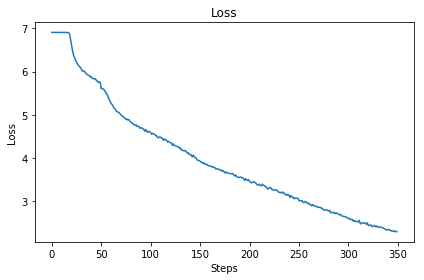

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 7] Accuracy on the test set: 55.36%
[Sample result]
tensor([[1, 1],
        [5, 5],
        [8, 8],
        [4, 4],
        [6, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 100.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 8] [Batch 100] Loss: 2.2661
[Epoch 8] [Batch 200] Loss: 2.2547
[Epoch 8] [Batch 300] Loss: 2.2676
[Epoch 8] [Batch 400] Loss: 2.2448
[Epoch 8] [Batch 500] Loss: 2.2472
[Epoch 8] [Batch 600] Loss: 2.2316
[Epoch 8] [Batch 700] Loss: 2.2378
[Epoch 8] [Batch 800] Loss: 2.2293
[Epoch 8] [Batch 900] Loss: 2.1988
[Epoch 8] [Batch 1000] Loss: 2.1812
[Epoch 8] [Batch 1100] Loss: 2.2043
[Epoch 8] [Batch 1200] Loss: 2.2103
[Epoch 8] [Batch 1300] Loss: 2.1971
[Epoch 8] [Batch 1400] Loss: 2.1929
[Epoch 8] [Batch 1500] Loss: 2.1742
[Epoch 8] [Batch 1600] Loss: 2.2042
[Epoch 8] [Batch 1700] Loss: 2.1584
[Epoch 8] [Batch 1800] Loss: 2.1711
[Epoch 8] [Batch 1900] Loss: 2.1581
[Epoch 8] [Batch 2000] Loss: 2.1517
[Epoch 8] [Batch 2100] Loss: 2.1656
[Epoch 8] [Batch 2200] Loss: 2.1591
[Epoch 8] [Batch 2300] Loss: 2.1622
[Epoch 8] [Batch 2400] Loss: 2.1429
[Epoch 8] [Batch 2500] Loss: 2.1325
[Epoch 8] [Batch 2600] Loss: 2.1551
[Epoch 8] [Batch 2700] Loss: 2.1193
[Epoch 8] [Batch 2800] Loss: 2.1300
[

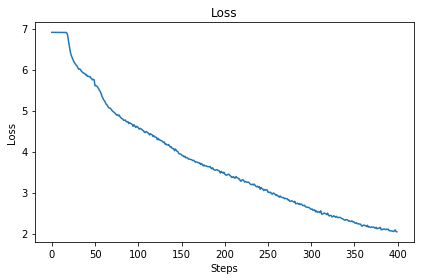

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 8] Accuracy on the test set: 59.79%
[Sample result]
tensor([[5, 1],
        [7, 5],
        [6, 8],
        [4, 4],
        [1, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [8, 7]])
Accuracy: 44.44%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 9] [Batch 100] Loss: 2.0127
[Epoch 9] [Batch 200] Loss: 2.0105
[Epoch 9] [Batch 300] Loss: 2.0281
[Epoch 9] [Batch 400] Loss: 2.0323
[Epoch 9] [Batch 500] Loss: 1.9913
[Epoch 9] [Batch 600] Loss: 2.0027
[Epoch 9] [Batch 700] Loss: 1.9804
[Epoch 9] [Batch 800] Loss: 2.0161
[Epoch 9] [Batch 900] Loss: 1.9962
[Epoch 9] [Batch 1000] Loss: 1.9983
[Epoch 9] [Batch 1100] Loss: 1.9842
[Epoch 9] [Batch 1200] Loss: 1.9794
[Epoch 9] [Batch 1300] Loss: 2.0209
[Epoch 9] [Batch 1400] Loss: 2.0034
[Epoch 9] [Batch 1500] Loss: 1.9858
[Epoch 9] [Batch 1600] Loss: 1.9695
[Epoch 9] [Batch 1700] Loss: 1.9736
[Epoch 9] [Batch 1800] Loss: 1.9455
[Epoch 9] [Batch 1900] Loss: 1.9547
[Epoch 9] [Batch 2000] Loss: 1.9676
[Epoch 9] [Batch 2100] Loss: 1.9583
[Epoch 9] [Batch 2200] Loss: 1.9524
[Epoch 9] [Batch 2300] Loss: 1.9374
[Epoch 9] [Batch 2400] Loss: 1.9485
[Epoch 9] [Batch 2500] Loss: 1.9547
[Epoch 9] [Batch 2600] Loss: 1.9413
[Epoch 9] [Batch 2700] Loss: 1.9381
[Epoch 9] [Batch 2800] Loss: 1.9434
[

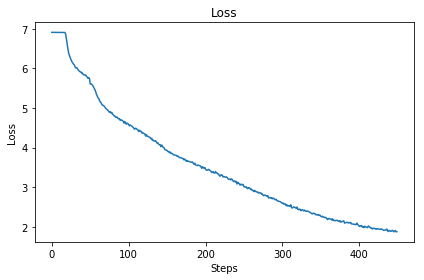

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 9] Accuracy on the test set: 62.17%
[Sample result]
tensor([[4, 1],
        [2, 5],
        [5, 8],
        [1, 4],
        [6, 6],
        [8, 2],
        [7, 3],
        [3, 0],
        [0, 7]])
Accuracy: 11.11%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 10] [Batch 100] Loss: 1.8519
[Epoch 10] [Batch 200] Loss: 1.8540
[Epoch 10] [Batch 300] Loss: 1.8436
[Epoch 10] [Batch 400] Loss: 1.8443
[Epoch 10] [Batch 500] Loss: 1.8481
[Epoch 10] [Batch 600] Loss: 1.8464
[Epoch 10] [Batch 700] Loss: 1.8440
[Epoch 10] [Batch 800] Loss: 1.8343
[Epoch 10] [Batch 900] Loss: 1.8497
[Epoch 10] [Batch 1000] Loss: 1.8057
[Epoch 10] [Batch 1100] Loss: 1.8199
[Epoch 10] [Batch 1200] Loss: 1.8190
[Epoch 10] [Batch 1300] Loss: 1.7959
[Epoch 10] [Batch 1400] Loss: 1.8207
[Epoch 10] [Batch 1500] Loss: 1.8366
[Epoch 10] [Batch 1600] Loss: 1.8346
[Epoch 10] [Batch 1700] Loss: 1.8193
[Epoch 10] [Batch 1800] Loss: 1.8035
[Epoch 10] [Batch 1900] Loss: 1.8203
[Epoch 10] [Batch 2000] Loss: 1.7893
[Epoch 10] [Batch 2100] Loss: 1.8123
[Epoch 10] [Batch 2200] Loss: 1.8152
[Epoch 10] [Batch 2300] Loss: 1.8126
[Epoch 10] [Batch 2400] Loss: 1.7868
[Epoch 10] [Batch 2500] Loss: 1.7539
[Epoch 10] [Batch 2600] Loss: 1.7862
[Epoch 10] [Batch 2700] Loss: 1.7960
[Epoch 10]

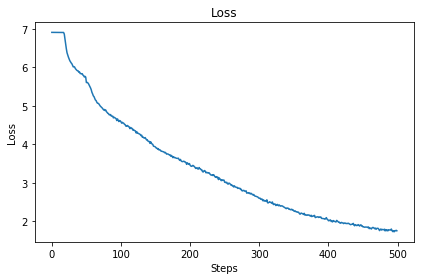

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 10] Accuracy on the test set: 64.78%
[Sample result]
tensor([[1, 1],
        [5, 5],
        [8, 8],
        [4, 4],
        [6, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 100.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 11] [Batch 100] Loss: 1.7162
[Epoch 11] [Batch 200] Loss: 1.7023
[Epoch 11] [Batch 300] Loss: 1.7298
[Epoch 11] [Batch 400] Loss: 1.6784
[Epoch 11] [Batch 500] Loss: 1.7034
[Epoch 11] [Batch 600] Loss: 1.7024
[Epoch 11] [Batch 700] Loss: 1.7136
[Epoch 11] [Batch 800] Loss: 1.6817
[Epoch 11] [Batch 900] Loss: 1.7089
[Epoch 11] [Batch 1000] Loss: 1.6769
[Epoch 11] [Batch 1100] Loss: 1.6737
[Epoch 11] [Batch 1200] Loss: 1.7058
[Epoch 11] [Batch 1300] Loss: 1.7119
[Epoch 11] [Batch 1400] Loss: 1.6812
[Epoch 11] [Batch 1500] Loss: 1.6772
[Epoch 11] [Batch 1600] Loss: 1.6750
[Epoch 11] [Batch 1700] Loss: 1.6922
[Epoch 11] [Batch 1800] Loss: 1.6921
[Epoch 11] [Batch 1900] Loss: 1.6988
[Epoch 11] [Batch 2000] Loss: 1.6765
[Epoch 11] [Batch 2100] Loss: 1.6888
[Epoch 11] [Batch 2200] Loss: 1.6710
[Epoch 11] [Batch 2300] Loss: 1.6439
[Epoch 11] [Batch 2400] Loss: 1.6463
[Epoch 11] [Batch 2500] Loss: 1.6674
[Epoch 11] [Batch 2600] Loss: 1.6643
[Epoch 11] [Batch 2700] Loss: 1.6491
[Epoch 11]

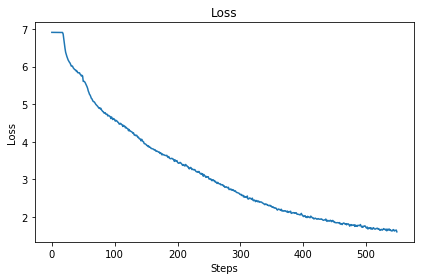

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 11] Accuracy on the test set: 66.13%
[Sample result]
tensor([[1, 1],
        [5, 5],
        [8, 8],
        [4, 4],
        [6, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 100.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 12] [Batch 100] Loss: 1.5955
[Epoch 12] [Batch 200] Loss: 1.5999
[Epoch 12] [Batch 300] Loss: 1.6048
[Epoch 12] [Batch 400] Loss: 1.6137
[Epoch 12] [Batch 500] Loss: 1.6013
[Epoch 12] [Batch 600] Loss: 1.5955
[Epoch 12] [Batch 700] Loss: 1.6260
[Epoch 12] [Batch 800] Loss: 1.5810
[Epoch 12] [Batch 900] Loss: 1.6008
[Epoch 12] [Batch 1000] Loss: 1.5984
[Epoch 12] [Batch 1100] Loss: 1.5726
[Epoch 12] [Batch 1200] Loss: 1.6066
[Epoch 12] [Batch 1300] Loss: 1.5888
[Epoch 12] [Batch 1400] Loss: 1.5535
[Epoch 12] [Batch 1500] Loss: 1.5729
[Epoch 12] [Batch 1600] Loss: 1.5690
[Epoch 12] [Batch 1700] Loss: 1.6003
[Epoch 12] [Batch 1800] Loss: 1.5774
[Epoch 12] [Batch 1900] Loss: 1.5835
[Epoch 12] [Batch 2000] Loss: 1.5657
[Epoch 12] [Batch 2100] Loss: 1.5744
[Epoch 12] [Batch 2200] Loss: 1.5781
[Epoch 12] [Batch 2300] Loss: 1.5880
[Epoch 12] [Batch 2400] Loss: 1.5710
[Epoch 12] [Batch 2500] Loss: 1.5685
[Epoch 12] [Batch 2600] Loss: 1.5844
[Epoch 12] [Batch 2700] Loss: 1.5853
[Epoch 12]

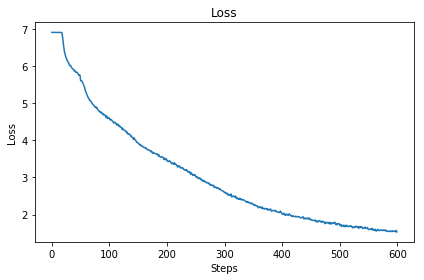

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 12] Accuracy on the test set: 67.91%
[Sample result]
tensor([[1, 1],
        [5, 5],
        [8, 8],
        [4, 4],
        [6, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 100.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 13] [Batch 100] Loss: 1.5437
[Epoch 13] [Batch 200] Loss: 1.5065
[Epoch 13] [Batch 300] Loss: 1.5258
[Epoch 13] [Batch 400] Loss: 1.5301
[Epoch 13] [Batch 500] Loss: 1.5278
[Epoch 13] [Batch 600] Loss: 1.4850
[Epoch 13] [Batch 700] Loss: 1.5188
[Epoch 13] [Batch 800] Loss: 1.4984
[Epoch 13] [Batch 900] Loss: 1.5113
[Epoch 13] [Batch 1000] Loss: 1.5250
[Epoch 13] [Batch 1100] Loss: 1.5048
[Epoch 13] [Batch 1200] Loss: 1.5048
[Epoch 13] [Batch 1300] Loss: 1.4863
[Epoch 13] [Batch 1400] Loss: 1.5209
[Epoch 13] [Batch 1500] Loss: 1.5093
[Epoch 13] [Batch 1600] Loss: 1.4967
[Epoch 13] [Batch 1700] Loss: 1.4828
[Epoch 13] [Batch 1800] Loss: 1.4781
[Epoch 13] [Batch 1900] Loss: 1.4889
[Epoch 13] [Batch 2000] Loss: 1.4987
[Epoch 13] [Batch 2100] Loss: 1.4977
[Epoch 13] [Batch 2200] Loss: 1.5065
[Epoch 13] [Batch 2300] Loss: 1.4724
[Epoch 13] [Batch 2400] Loss: 1.5002
[Epoch 13] [Batch 2500] Loss: 1.5040
[Epoch 13] [Batch 2600] Loss: 1.4842
[Epoch 13] [Batch 2700] Loss: 1.4935
[Epoch 13]

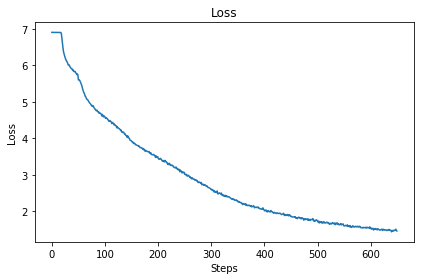

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 13] Accuracy on the test set: 69.07%
[Sample result]
tensor([[1, 1],
        [5, 5],
        [8, 8],
        [4, 4],
        [6, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 100.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 14] [Batch 100] Loss: 1.4499
[Epoch 14] [Batch 200] Loss: 1.4771
[Epoch 14] [Batch 300] Loss: 1.4499
[Epoch 14] [Batch 400] Loss: 1.4741
[Epoch 14] [Batch 500] Loss: 1.4287
[Epoch 14] [Batch 600] Loss: 1.4600
[Epoch 14] [Batch 700] Loss: 1.4321
[Epoch 14] [Batch 800] Loss: 1.4472
[Epoch 14] [Batch 900] Loss: 1.4387
[Epoch 14] [Batch 1000] Loss: 1.4432
[Epoch 14] [Batch 1100] Loss: 1.4259
[Epoch 14] [Batch 1200] Loss: 1.4319
[Epoch 14] [Batch 1300] Loss: 1.4216
[Epoch 14] [Batch 1400] Loss: 1.4248
[Epoch 14] [Batch 1500] Loss: 1.4262
[Epoch 14] [Batch 1600] Loss: 1.4287
[Epoch 14] [Batch 1700] Loss: 1.4419
[Epoch 14] [Batch 1800] Loss: 1.4099
[Epoch 14] [Batch 1900] Loss: 1.4286
[Epoch 14] [Batch 2000] Loss: 1.4202
[Epoch 14] [Batch 2100] Loss: 1.4070
[Epoch 14] [Batch 2200] Loss: 1.4631
[Epoch 14] [Batch 2300] Loss: 1.4204
[Epoch 14] [Batch 2400] Loss: 1.4198
[Epoch 14] [Batch 2500] Loss: 1.4152
[Epoch 14] [Batch 2600] Loss: 1.4037
[Epoch 14] [Batch 2700] Loss: 1.4268
[Epoch 14]

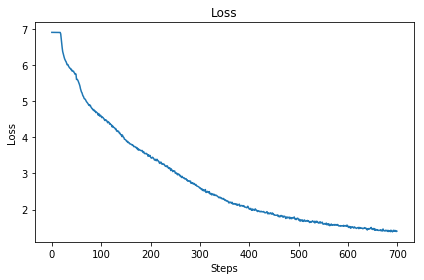

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 14] Accuracy on the test set: 69.94%
[Sample result]
tensor([[1, 1],
        [5, 5],
        [8, 8],
        [4, 4],
        [6, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 100.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 15] [Batch 100] Loss: 1.3945
[Epoch 15] [Batch 200] Loss: 1.4055
[Epoch 15] [Batch 300] Loss: 1.3581
[Epoch 15] [Batch 400] Loss: 1.3826
[Epoch 15] [Batch 500] Loss: 1.3908
[Epoch 15] [Batch 600] Loss: 1.4111
[Epoch 15] [Batch 700] Loss: 1.4004
[Epoch 15] [Batch 800] Loss: 1.3867
[Epoch 15] [Batch 900] Loss: 1.3595
[Epoch 15] [Batch 1000] Loss: 1.3863
[Epoch 15] [Batch 1100] Loss: 1.3655
[Epoch 15] [Batch 1200] Loss: 1.3583
[Epoch 15] [Batch 1300] Loss: 1.4116
[Epoch 15] [Batch 1400] Loss: 1.3746
[Epoch 15] [Batch 1500] Loss: 1.3647
[Epoch 15] [Batch 1600] Loss: 1.3649
[Epoch 15] [Batch 1700] Loss: 1.3714
[Epoch 15] [Batch 1800] Loss: 1.3658
[Epoch 15] [Batch 1900] Loss: 1.3527
[Epoch 15] [Batch 2000] Loss: 1.3708
[Epoch 15] [Batch 2100] Loss: 1.3721
[Epoch 15] [Batch 2200] Loss: 1.3590
[Epoch 15] [Batch 2300] Loss: 1.3784
[Epoch 15] [Batch 2400] Loss: 1.3720
[Epoch 15] [Batch 2500] Loss: 1.3695
[Epoch 15] [Batch 2600] Loss: 1.3530
[Epoch 15] [Batch 2700] Loss: 1.3441
[Epoch 15]

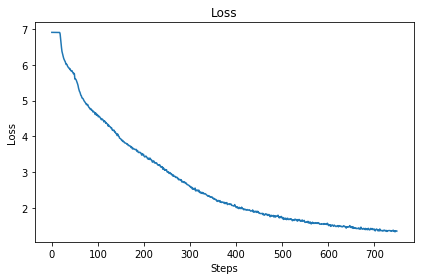

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 15] Accuracy on the test set: 70.91%
[Sample result]
tensor([[5, 1],
        [8, 5],
        [4, 8],
        [2, 4],
        [6, 6],
        [1, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 44.44%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 16] [Batch 100] Loss: 1.3381
[Epoch 16] [Batch 200] Loss: 1.3460
[Epoch 16] [Batch 300] Loss: 1.3214
[Epoch 16] [Batch 400] Loss: 1.3272
[Epoch 16] [Batch 500] Loss: 1.3145
[Epoch 16] [Batch 600] Loss: 1.3464
[Epoch 16] [Batch 700] Loss: 1.3163
[Epoch 16] [Batch 800] Loss: 1.3187
[Epoch 16] [Batch 900] Loss: 1.3337
[Epoch 16] [Batch 1000] Loss: 1.3419
[Epoch 16] [Batch 1100] Loss: 1.3324
[Epoch 16] [Batch 1200] Loss: 1.3290
[Epoch 16] [Batch 1300] Loss: 1.3046
[Epoch 16] [Batch 1400] Loss: 1.3311
[Epoch 16] [Batch 1500] Loss: 1.3465
[Epoch 16] [Batch 1600] Loss: 1.3372
[Epoch 16] [Batch 1700] Loss: 1.3157
[Epoch 16] [Batch 1800] Loss: 1.3581
[Epoch 16] [Batch 1900] Loss: 1.3197
[Epoch 16] [Batch 2000] Loss: 1.3432
[Epoch 16] [Batch 2100] Loss: 1.3247
[Epoch 16] [Batch 2200] Loss: 1.3234
[Epoch 16] [Batch 2300] Loss: 1.3255
[Epoch 16] [Batch 2400] Loss: 1.3325
[Epoch 16] [Batch 2500] Loss: 1.3168
[Epoch 16] [Batch 2600] Loss: 1.3362
[Epoch 16] [Batch 2700] Loss: 1.3392
[Epoch 16]

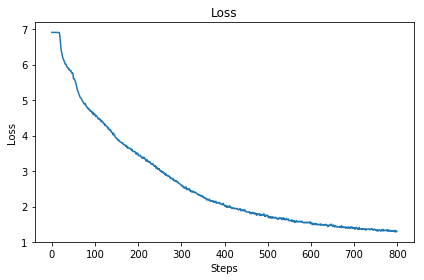

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 16] Accuracy on the test set: 72.30%
[Sample result]
tensor([[1, 1],
        [5, 5],
        [8, 8],
        [4, 4],
        [6, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 100.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 17] [Batch 100] Loss: 1.2923
[Epoch 17] [Batch 200] Loss: 1.3004
[Epoch 17] [Batch 300] Loss: 1.3048
[Epoch 17] [Batch 400] Loss: 1.2798
[Epoch 17] [Batch 500] Loss: 1.2858
[Epoch 17] [Batch 600] Loss: 1.2884
[Epoch 17] [Batch 700] Loss: 1.3059
[Epoch 17] [Batch 800] Loss: 1.2891
[Epoch 17] [Batch 900] Loss: 1.2920
[Epoch 17] [Batch 1000] Loss: 1.2761
[Epoch 17] [Batch 1100] Loss: 1.2782
[Epoch 17] [Batch 1200] Loss: 1.2738
[Epoch 17] [Batch 1300] Loss: 1.2993
[Epoch 17] [Batch 1400] Loss: 1.2965
[Epoch 17] [Batch 1500] Loss: 1.2831
[Epoch 17] [Batch 1600] Loss: 1.2801
[Epoch 17] [Batch 1700] Loss: 1.2822
[Epoch 17] [Batch 1800] Loss: 1.2811
[Epoch 17] [Batch 1900] Loss: 1.3180
[Epoch 17] [Batch 2000] Loss: 1.2872
[Epoch 17] [Batch 2100] Loss: 1.2966
[Epoch 17] [Batch 2200] Loss: 1.2899
[Epoch 17] [Batch 2300] Loss: 1.2732
[Epoch 17] [Batch 2400] Loss: 1.2871
[Epoch 17] [Batch 2500] Loss: 1.3069
[Epoch 17] [Batch 2600] Loss: 1.2896
[Epoch 17] [Batch 2700] Loss: 1.2964
[Epoch 17]

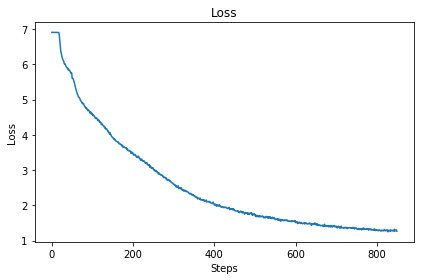

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 17] Accuracy on the test set: 72.48%
[Sample result]
tensor([[1, 1],
        [5, 5],
        [8, 8],
        [4, 4],
        [6, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 100.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 18] [Batch 100] Loss: 1.2851
[Epoch 18] [Batch 200] Loss: 1.2601
[Epoch 18] [Batch 300] Loss: 1.2669
[Epoch 18] [Batch 400] Loss: 1.2795
[Epoch 18] [Batch 500] Loss: 1.2887
[Epoch 18] [Batch 600] Loss: 1.2779
[Epoch 18] [Batch 700] Loss: 1.2812
[Epoch 18] [Batch 800] Loss: 1.2479
[Epoch 18] [Batch 900] Loss: 1.2463
[Epoch 18] [Batch 1000] Loss: 1.2767
[Epoch 18] [Batch 1100] Loss: 1.2559
[Epoch 18] [Batch 1200] Loss: 1.2655
[Epoch 18] [Batch 1300] Loss: 1.2538
[Epoch 18] [Batch 1400] Loss: 1.2664
[Epoch 18] [Batch 1500] Loss: 1.2627
[Epoch 18] [Batch 1600] Loss: 1.2613
[Epoch 18] [Batch 1700] Loss: 1.2654
[Epoch 18] [Batch 1800] Loss: 1.2719
[Epoch 18] [Batch 1900] Loss: 1.2503
[Epoch 18] [Batch 2000] Loss: 1.2543
[Epoch 18] [Batch 2100] Loss: 1.2575
[Epoch 18] [Batch 2200] Loss: 1.2388
[Epoch 18] [Batch 2300] Loss: 1.2530
[Epoch 18] [Batch 2400] Loss: 1.2524
[Epoch 18] [Batch 2500] Loss: 1.2324
[Epoch 18] [Batch 2600] Loss: 1.2579
[Epoch 18] [Batch 2700] Loss: 1.2404
[Epoch 18]

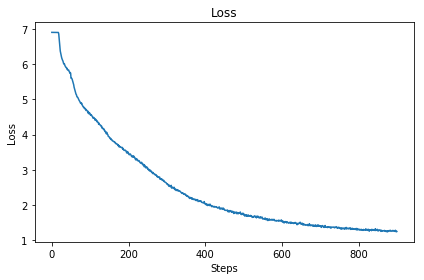

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 18] Accuracy on the test set: 73.07%
[Sample result]
tensor([[1, 1],
        [5, 5],
        [8, 8],
        [4, 4],
        [6, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 100.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 19] [Batch 100] Loss: 1.2663
[Epoch 19] [Batch 200] Loss: 1.2470
[Epoch 19] [Batch 300] Loss: 1.2457
[Epoch 19] [Batch 400] Loss: 1.2333
[Epoch 19] [Batch 500] Loss: 1.2568
[Epoch 19] [Batch 600] Loss: 1.2414
[Epoch 19] [Batch 700] Loss: 1.2439
[Epoch 19] [Batch 800] Loss: 1.2456
[Epoch 19] [Batch 900] Loss: 1.2402
[Epoch 19] [Batch 1000] Loss: 1.2492
[Epoch 19] [Batch 1100] Loss: 1.2484
[Epoch 19] [Batch 1200] Loss: 1.2711
[Epoch 19] [Batch 1300] Loss: 1.2377
[Epoch 19] [Batch 1400] Loss: 1.2149
[Epoch 19] [Batch 1500] Loss: 1.2447
[Epoch 19] [Batch 1600] Loss: 1.2384
[Epoch 19] [Batch 1700] Loss: 1.2379
[Epoch 19] [Batch 1800] Loss: 1.2225
[Epoch 19] [Batch 1900] Loss: 1.2282
[Epoch 19] [Batch 2000] Loss: 1.2391
[Epoch 19] [Batch 2100] Loss: 1.2525
[Epoch 19] [Batch 2200] Loss: 1.2374
[Epoch 19] [Batch 2300] Loss: 1.2412
[Epoch 19] [Batch 2400] Loss: 1.2498
[Epoch 19] [Batch 2500] Loss: 1.2298
[Epoch 19] [Batch 2600] Loss: 1.2360
[Epoch 19] [Batch 2700] Loss: 1.2375
[Epoch 19]

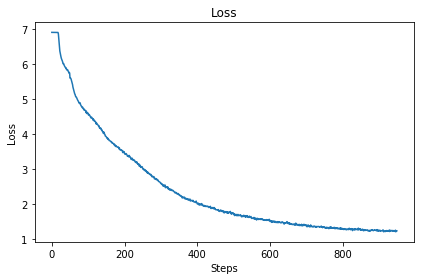

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 19] Accuracy on the test set: 73.34%
[Sample result]
tensor([[1, 1],
        [5, 5],
        [8, 8],
        [4, 4],
        [6, 6],
        [2, 2],
        [3, 3],
        [0, 0],
        [7, 7]])
Accuracy: 100.00%


  0%|          | 0/5005 [00:00<?, ?it/s]

[Epoch 20] [Batch 100] Loss: 1.2431
[Epoch 20] [Batch 200] Loss: 1.2261
[Epoch 20] [Batch 300] Loss: 1.2606
[Epoch 20] [Batch 400] Loss: 1.2270
[Epoch 20] [Batch 500] Loss: 1.2481
[Epoch 20] [Batch 600] Loss: 1.2313
[Epoch 20] [Batch 700] Loss: 1.2358
[Epoch 20] [Batch 800] Loss: 1.2247
[Epoch 20] [Batch 900] Loss: 1.2366
[Epoch 20] [Batch 1000] Loss: 1.2384
[Epoch 20] [Batch 1100] Loss: 1.2297
[Epoch 20] [Batch 1200] Loss: 1.2373
[Epoch 20] [Batch 1300] Loss: 1.2514
[Epoch 20] [Batch 1400] Loss: 1.2445
[Epoch 20] [Batch 1500] Loss: 1.2616
[Epoch 20] [Batch 1600] Loss: 1.2426
[Epoch 20] [Batch 1700] Loss: 1.2171
[Epoch 20] [Batch 1800] Loss: 1.2464
[Epoch 20] [Batch 1900] Loss: 1.2204
[Epoch 20] [Batch 2000] Loss: 1.2194
[Epoch 20] [Batch 2100] Loss: 1.2386
[Epoch 20] [Batch 2200] Loss: 1.2342
[Epoch 20] [Batch 2300] Loss: 1.2362
[Epoch 20] [Batch 2400] Loss: 1.2467
[Epoch 20] [Batch 2500] Loss: 1.2472
[Epoch 20] [Batch 2600] Loss: 1.2244
[Epoch 20] [Batch 2700] Loss: 1.2373
[Epoch 20]

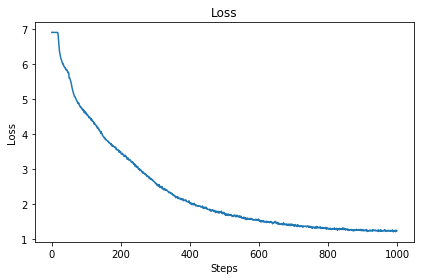

  0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 20] Accuracy on the test set: 72.95%
[Sample result]
tensor([[5, 1],
        [2, 5],
        [8, 8],
        [1, 4],
        [6, 6],
        [4, 2],
        [0, 3],
        [7, 0],
        [3, 7]])
Accuracy: 22.22%
****** Finished Fine-tuning ******
****** Model checkpoint saved at epochs 20 ******


In [5]:
if __name__ == '__main__':
    trainer = PreTrainer()
    trainer.process(load=False)

In [8]:
'''
epochs 5에서 사전 테스트

permutation = 1000, shortcut 방지x, +Adam
-> batch_size=256, lr=2e-05 : 97.69%
-> batch_size=256, lr=3e-05 : 97.97%
-> batch_size=256, lr=4e-05 : 97.92%
-> batch_size=256, lr=5e-05 : 98.24%
-> Acc 너무 높음. 평가 불가. shortcut 방지 필요함.

permutation = 1000, shortcut 방지o, +Adam
-> batch_size=256, lr=4e-05 : 33.44%
-> batch_size=256, lr=5e-05 : 37.61%
-> batch_size=256, lr=6e-05 : 38.69%
-> batch_size=256, lr=7e-05 : 40.13%  -> epochs 20, 73.34% (더 진행하면 떨어짐, 과적합)
-> batch_size=256, lr=8e-05 : 37.94%
-> batch_size=256, lr=9e-05 : 38.66%
-> batch_size=256, lr=1e-04 : 11.06%


1 에포크 = 3시간 반
5 에포크 = 17시간 반
'''

'\nepochs 5에서 사전 테스트\n\npermutation = 1000, shortcut 방지x, +Adam\n-> batch_size=256, lr=2e-05 : 97.69%\n-> batch_size=256, lr=3e-05 : 97.97%\n-> batch_size=256, lr=4e-05 : 97.92%\n-> batch_size=256, lr=5e-05 : 98.24%\n-> Acc 너무 높음. 평가 불가. shortcut 방지 필요함.\n\npermutation = 1000, shortcut 방지o, +Adam\n-> batch_size=256, lr=4e-05 : 33.44%\n-> batch_size=256, lr=5e-05 : 37.61%\n-> batch_size=256, lr=6e-05 : 38.69%\n-> batch_size=256, lr=7e-05 : 40.13%  -> epochs 20, 73.34% (더 진행하면 떨어짐, 과적합)\n-> batch_size=256, lr=8e-05 : 37.94%\n-> batch_size=256, lr=9e-05 : 38.66%\n-> batch_size=256, lr=1e-04 : 11.06%\n\n\n1 에포크 = 3시간 반\n5 에포크 = 17시간 반\n'